# Investigate a Dataset - Titanic Data

## What factors made people more likely to survive?

In [4]:
from scripts import titanic
titanic_obj = titanic.titanic_analysis()

### Titanic Data

Contains demographics and passenger information from 891 of the 2224 passengers and crew on board the Titanic. You can view a description of this dataset on [the Kaggle website](https://www.kaggle.com/c/titanic/data), where the data was obtained.

### Numerical Analysis

#### Basic overview of variables

In [73]:
titanic_obj.titanic_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* highly `Pclass`, less `Fare` is the most strongly relationship 

In [71]:
titanic_obj.titanic_data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


* There is no strongly relationship between `Age` and `Fare`

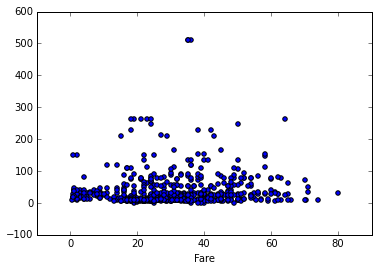

In [66]:
%matplotlib inline 
import matplotlib.pyplot as plt
fig1 = plt.figure(1)
ax1 = fig1.add_subplot(111)
x=ax1.scatter(titanic_obj.titanic_data.Age, titanic_obj.titanic_data.Fare, marker = 'o')
plt.xlabel('Age')
plt.xlabel('Fare')

#### Basic overview of count

In [107]:
import collections
def get_count(input_list):
    return collections.Counter(input_list).items()
print 'Survived: ' + str(get_count(titanic_obj.titanic_data.Survived))
print 
print 'Pclass: ' + str(get_count(titanic_obj.titanic_data.Pclass))
print 
print 'Sex: ' + str(get_count(titanic_obj.titanic_data.Sex))
print 
print 'SibSp: ' + str(get_count(titanic_obj.titanic_data.SibSp))
print 
print 'Parch: ' + str(get_count(titanic_obj.titanic_data.Parch))
# print 
# print 'Ticket: ' + str(get_count(titanic_obj.titanic_data.Ticket))
# print
# print 'Cabin: ' + str(get_count(titanic_obj.titanic_data.Cabin))

Survived: [(0, 549), (1, 342)]

Pclass: [(1, 216), (2, 184), (3, 491)]

Sex: [('male', 577), ('female', 314)]

SibSp: [(0, 608), (1, 209), (2, 28), (3, 16), (4, 18), (5, 5), (8, 7)]

Parch: [(0, 678), (1, 118), (2, 80), (3, 5), (4, 4), (5, 5), (6, 1)]


* `Ticket` and `Cabin` are too dispersed

* Not survival is more than survived, male is more than female

* Mode for `Pclass` is 3, 0 for `SibSp` and `Parch`

In [27]:
titanic_obj.titanic_data.groupby(['Sex', 'Survived'])[['Survived']].count()

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

* The overall survival rate is just 38%, but for woman is 74%, so `Sex` may be an important factor affecting survival

In [34]:
titanic_obj.titanic_data.groupby(['Pclass', 'Sex']).mean()

PassengerId  Survived        Age     SibSp     Parch  \
Pclass Sex                                                            
1      female   469.212766  0.968085  34.611765  0.553191  0.457447   
       male     455.729508  0.368852  41.281386  0.311475  0.278689   
2      female   443.105263  0.921053  28.722973  0.486842  0.605263   
       male     447.962963  0.157407  30.740707  0.342593  0.222222   
3      female   399.729167  0.500000  21.750000  0.895833  0.798611   
       male     455.515850  0.135447  26.507589  0.498559  0.224784   

                     Fare  
Pclass Sex                 
1      female  106.125798  
       male     67.226127  
2      female   21.970121  
       male     19.741782  
3      female   16.118810  
       male     12.661633

In [68]:
titanic_obj.titanic_data.groupby(['Pclass', 'Sex']).median()

PassengerId  Survived   Age  SibSp  Parch      Fare
Pclass Sex                                                        
1      female        447.0       1.0  35.0      0      0  82.66455
       male          480.5       0.0  40.0      0      0  41.26250
2      female        439.5       1.0  28.0      0      0  22.00000
       male          416.5       0.0  30.0      0      0  13.00000
3      female        376.0       0.5  21.5      0      0  12.47500
       male          466.0       0.0  25.0      0      0   7.92500

* Survival rate for first `Pclass` is high no matter male or female, furthermore, the average `Age` and `Fare` are also highest

In [2]:
N = titanic_obj.titanic_data.shape[0] #sample size
print 'overall survival rate is ' + str(float(titanic_obj.titanic_data.Survived.sum())/N)
N_female = titanic_obj.titanic_data[titanic_obj.titanic_data.Sex == 'female'].shape[0]
print 'survival rate for woman is ' + \
        str(float(titanic_obj.titanic_data[titanic_obj.titanic_data.Sex == 'female'].Survived.sum())/N_female)

overall survival rate is 0.383838383838
survival rate for woman is 0.742038216561


* `Cabin` have too many missing values, we choose to ignore this column, because it can not provide much information
* Just two missing values in `Embarked`, ignore the data from these two will not have much of an impact to analysis results
* I think `Age` may be one of the key factors affecting the survival, it is necessary to deal with missing values, detailed processing procedure will be discuss later 

In [3]:
titanic_obj.titanic_data.isnull().sum() # get numbers of nan for each column

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Data Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000000020E85C88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000000020AA34A8>]], dtype=object)

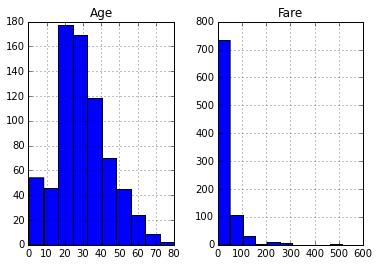

In [46]:
titanic_obj.titanic_data.iloc[:,[5, 9]].hist(bins=10)

* The right tail for `Fare` is longer

{'boxes': [<matplotlib.lines.Line2D at 0x303dfb00>,
 'caps': [<matplotlib.lines.Line2D at 0x303ec8d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x30438978>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x30438400>,
 'whiskers': [<matplotlib.lines.Line2D at 0x303dfd30>,
  <matplotlib.lines.Line2D at 0x304439e8>]}

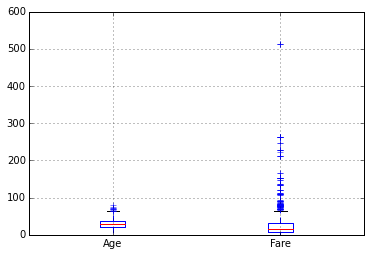

In [54]:
titanic_obj.titanic_data.iloc[:,[5, 9]].boxplot()

* There are many outliers distant from other observations in `Fare` 

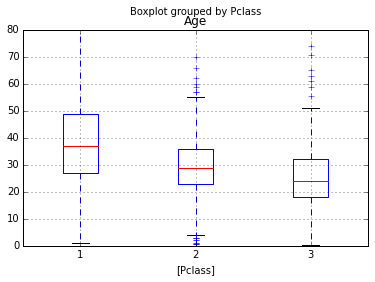

In [58]:
titanic_obj.titanic_data.iloc[:,[2, 5]].boxplot(by='Pclass')

* As a result of Numerical Analysis, the mediane `Age` for first `Pclass` is highest

* As a result of Numerical Analysis, data visualization shows more apparent effects of gender on survival

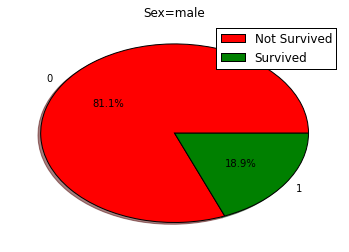

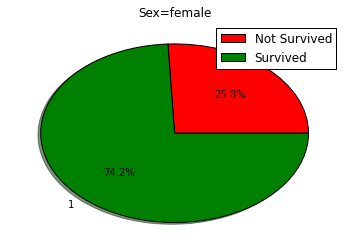

In [4]:
titanic_obj.draw_pie_chart('Sex', 'male')
titanic_obj.draw_pie_chart('Sex', 'female')

* Then we do a further two-dimensional graphical treemap for sex, which block represents sample size and the color represents suvival rate

* Get data for treemap by the following method

In [5]:
titanic_obj.get_treemap('Sex', 'Pclass')

'[["Location", "Parent", "Numbers of Passenger(size)", "Survival Rate(color)"], ["Sex&Pclass", null, 0, 0], ["Sex=female&Pclass=1", "Sex&Pclass", 94, 0.9680851063829787], ["Sex=female&Pclass=2", "Sex&Pclass", 76, 0.9210526315789473], ["Sex=female&Pclass=3", "Sex&Pclass", 144, 0.5], ["Sex=male&Pclass=1", "Sex&Pclass", 122, 0.36885245901639346], ["Sex=male&Pclass=2", "Sex&Pclass", 108, 0.1574074074074074], ["Sex=male&Pclass=3", "Sex&Pclass", 347, 0.13544668587896252]]'

* Although the survival rate of women higher than men, but women in `Pclass` = 3 women are not so lucky

![img1](https://raw.githubusercontent.com/ShaneKao/Titanic-Data/master/Analyzing_the_NYC_Subway_Dataset/image/pclass3_female.png)

In [56]:
survival_pclass3_female = titanic_obj.titanic_data[titanic_obj.titanic_data.Sex=='female'] \
                                                [titanic_obj.titanic_data.Pclass==3].Survived.tolist()
'survival rate for pclass = 3 and female is ' + str(float(sum(survival_pclass3_female))/float(len(survival_pclass3_female)))

'survival rate for pclass = 3 and female is 0.5'

### Data Wrangling

* Delete `Cabin` & Delete missing values of `Embarked` 

* Salutation in `Name` provide us rough guess for `Age`, the following figure shows the highly relationship between these two variable

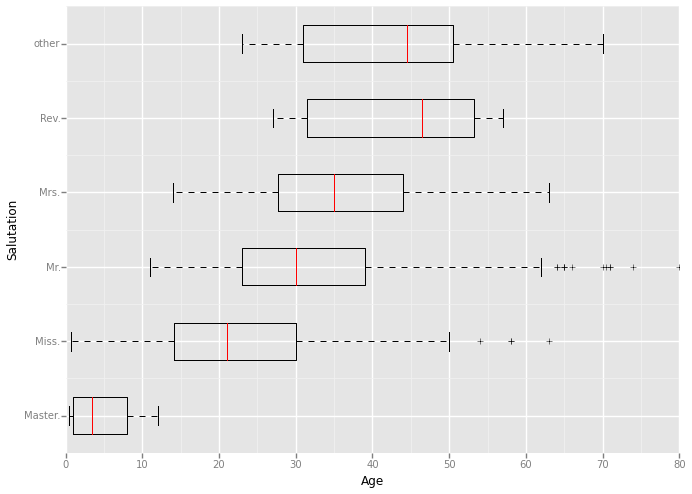

<ggplot: (34428402)>

In [6]:
from ggplot import *
df = titanic_obj.titanic_data
df['Salutation'] = df.apply(lambda x: titanic_obj.get_salutation(x['Name']), axis=1)
ggplot(df, aes(x='Age', y='Salutation')) + geom_boxplot()

* We use the median age of the same `Salutation` to fill the missing values of `Age`

* Show data that ready for analysis

In [7]:
titanic_obj.titanic_data_cleaned

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Salutation
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,S,Mr.
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C,Mrs.
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,S,Miss.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,S,Mrs.
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,S,Mr.
5,6,0,3,"Moran, Mr. James",male,30,0,0,330877,8.4583,Q,Mr.
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,S,Mr.
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,S,Master.
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,S,Mrs.
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,C,Mrs.


### Data Analysis

#### chi-square-test

* null: survival rates for `male` and `female` are equal
* alternative: survival rates for `female` is higher than `female`
    

In [84]:
titanic_obj.titanic_data.groupby(['Sex', 'Survived'])['PassengerId'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: PassengerId, dtype: int64

In [82]:
from scipy import stats
import numpy as np
survivors = np.array([[109,233], [468, 81]])
'p-value = ' +str(stats.chi2_contingency(survivors)[1])

'p-value = 1.19735706278e-58'

* Reject null hypothesis, accept survival rates for `female` is higher than `female`

#### Apriori

USE Apriori to find frequent set which is contains `Survived`

* Consider `Survived`, `Pclass`, `Sex`, `SibSp`, `Parch`, `Embarked`, `Salutation`

In [144]:
df = titanic_obj.titanic_data_cleaned
df = df.iloc[:,[1, 2, 4, 6, 7, 10, 11]]

* set minsup to 0.4 

In [145]:
from scripts.apriori import apriori
### add prefix ###
def add_prefix(col_name):
    df[col_name] = df[col_name].apply(lambda x: col_name + ' = ' + str(x))    
for i in df.columns:
    add_prefix(i)
F = apriori(df.values.tolist(), 0.4)

C:\Users\shane\Anaconda\lib\site-packages\IPython\kernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


* The frequent set which is contains Survived

In [146]:
for i in F:
    if 'Survived = 0' in i or 'Survived = 1' in i:
        print i

['Survived = 0']
['Embarked = S', 'Survived = 0']
['Parch = 0', 'Survived = 0']
['Pclass = 3', 'Survived = 0']
['Salutation = Mr.', 'Survived = 0']
['Sex = male', 'Survived = 0']
['SibSp = 0', 'Survived = 0']
['Embarked = S', 'Sex = male', 'Survived = 0']
['Parch = 0', 'Salutation = Mr.', 'Survived = 0']
['Parch = 0', 'Salutation = Mr.', 'Sex = male', 'Survived = 0']
['Parch = 0', 'Sex = male', 'Survived = 0']
['Parch = 0', 'SibSp = 0', 'Survived = 0']
['Salutation = Mr.', 'Sex = male', 'Survived = 0']
['Sex = male', 'SibSp = 0', 'Survived = 0']
['Parch = 0', 'Salutation = Mr.', 'Sex = male', 'Survived = 0']


* `Sex` = male and 'Survived = 0' occurs frequently, such a result is consistent with the previous visualization results, moreover, `SibSp` = 0, `Parch` = 0, `Embarked` = S and `Pclass` = 3 have less survival rate

* The results did not include any frequent sets containing `Survived` = 1, because overall survival rate about 38% and we set minsup to 0.4, if we lower minsup, the results will be too messy, too many frequently set, not easy to read

#### Decision Trees

* Consider `Survived`, `Pclass`, `Sex`, `SibSp`, `Parch`, `Embarked`, `Salutation`, `Age`, `Fare`

In [147]:
df = titanic_obj.titanic_data_cleaned
df_X = df.iloc[:,[2, 4, 5, 6, 7, 9, 10, 11]]

* Label encoder, as follows
* Sex = male -> 1, Sex = female -> 0
* Embarked = C -> 0, Embarked = Q -> 1, Embarked = S -> 2
* Salutation = 	Dr. -> 0, Salutation = Master. -> 1, Salutation = Miss. -> 2, Salutation = 	Mr. -> 3, Salutation = 	Mrs. -> 4,  Salutation = Rev. -> 5
    

In [148]:
### Label encoder ###
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
def give_label(col_name):
    df_X[col_name] = lb.fit_transform(df_X[col_name])
for i in ['Sex', 'Embarked', 'Salutation']:
    give_label(i)
# df_X.Sex = lb.fit_transform(df_X.Sex)
# df_X.Embarked = lb.fit_transform(df_X.Embarked)
# df_X.Salutation = lb.fit_transform(df_X.Salutation)

C:\Users\shane\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


* Train tree model, where `max_depth` means the maximum depth of the tree, `min_samples_leaf` is The minimum number of samples required to be at a leaf node and max_leaf_nodes means grow a tree with max_leaf_nodes in best-first fashion. 

In [149]:
import numpy as np
from sklearn import tree
X = np.array(df_X.values.tolist())
Y = np.array(df.Survived.tolist())
clf = tree.DecisionTreeClassifier(max_depth = 3, min_samples_leaf = 3, max_leaf_nodes = 5)
clf.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=5, min_samples_leaf=3,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

* Show feature importances(the higher, the more important the feature).

In [150]:
importances = clf.feature_importances_
feature_names = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Salutation']
for i in range(len(importances)):
    print feature_names[i] + ':' + str(list(importances)[i])

Pclass:0.167466824166
Sex:0.667406237544
Age:0.0
SibSp:0.0956964150045
Parch:0.0
Fare:0.0
Embarked:0.0
Salutation:0.069430523286


* important features: `Sex` > `Pclass` > `SibSp` > `Salutation`

* Find rule

In [151]:
from scripts.tree_rule import get_rule
get_rule(clf, feature_names)

if ( Sex < 0.5 ) {
if ( Pclass < 2.5 ) {
return [[   9.  159.]]
} else {
return [[ 72.  72.]]
}
} else {
if ( Salutation < 1.0 ) {
if ( SibSp < 2.5 ) {
return [[  0.  22.]]
} else {
return [[ 17.   1.]]
}
} else {
return [[ 451.   86.]]
}
}


* Use the above results for the word tree data visualization

![img2](https://raw.githubusercontent.com/ShaneKao/Titanic-Data/master/Analyzing_the_NYC_Subway_Dataset/image/tree_result.png)

* Although male survival rate is low, but child for sibsp in 0,1 and 2 all survived

### Discussion

* All results show the survival rate of women higher than men

* `Age` is not in tree model, probably because there is a strong relation with `Salutation`

* Tree model results obtained more detailed than apiori, which is not restricted by minsup

### Limitation

* The dataset is filled with missing values. Whatever way we choose to handle these missing values (omitting, imputing, etc.) presents its own pros and cons.

* `Ticket` and `Cabin` are dispersive, it will cost too many degrees of freedom in statistical analysis.

### Reference

* [ggplot](http://ggplot.yhathq.com/)

* [pandas](http://pandas.pydata.org/pandas-docs/stable/)

* [matplotlib](http://matplotlib.org/contents.html)

* [google chart](https://developers.google.com/chart/interactive/docs/?hl=zh-TW)

* [apriori](http://www.jianshu.com/p/00103435ef89)

* [Get Tree Rlue](http://stackoverflow.com/questions/20224526/how-to-extract-the-decision-rules-from-scikit-learn-decision-tree)